In [2]:
import networkx as nx
import numpy as np
import pandas as pd
from pyvis.network import Network
import matplotlib.pyplot as plt
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities
from scipy.cluster import hierarchy

MINIMAL_CONN_CNT = 50

In [3]:
def open_data(filename: str = "./data.csv", named_row: bool = False) -> pd.DataFrame:
    if named_row:
        data = pd.read_csv(filename, index_col=0)
    else:
        data = pd.read_csv(filename)

    return data

def create_graph(matrix: pd.DataFrame):
    val = matrix.values.tolist()
    net = Network(directed=True)
    ret_nx_net = nx.Graph()
    names = list(matrix.columns.values)

    for x in names:
        net.add_node(x, label=x)
        ret_nx_net.add_node(x, label=x)

    for x, valx in enumerate(val):
        for y, valy in enumerate(val):
            if (type(val[x][y]) != int):
                # print(f"{names[x]} !+! {val[x][y]} !+! {names[y]}")
                continue
            elif (val[x][y] < MINIMAL_CONN_CNT):
                continue
            else:
                ret_nx_net.add_edge(names[x], names[y], weight=val[x][y])
                net.add_edge(names[x], names[y], weight=val[x][y])

    net.toggle_physics(False)
    net.show_buttons(filter_=["physics"])
    net.save_graph('mygraph.html')

    return ret_nx_net

def draw(subset: list, original: nx.Graph, title: str, tofile = False):
    for idx,x in enumerate(subset):
        subgraph = original.subgraph(x)
        plt.figure()
        nx.draw(subgraph, with_labels=True, node_color=f"C{idx}", node_size=300)
        plt.title(f"{title} {idx+1}")
        plt.show()
    

In [69]:
def task3(G: nx.Graph):
    cliques = list(nx.find_cliques(G))
    print("Kliki:", cliques)

    modularity_communities = list(greedy_modularity_communities(G))
    print("Moduły:")
    for x in modularity_communities:
        print(x)

    distance_matrix = nx.to_numpy_array(G)
    Z = hierarchy.linkage(distance_matrix, method='complete')
    plt.figure(figsize=(10, 5))
    dn = hierarchy.dendrogram(Z)
    plt.title('Dendrogram')
    plt.show()

    # 3. Metody podziałowe
    # Girvan-Newman algorithm
    gn_communities = list(community.girvan_newman(G))
    print("Metoda podziałowa - Girvan-Newman:", list(sorted(c) for c in gn_communities))

    # 4. Porównanie metody aglomeracyjnej i metod podziałowych za pomocą modularności
    modularity_agglomerative = community.modularity(G, modularity_communities)
    print("Modularność - Metoda aglomeracyjna:", modularity_agglomerative)

    # 5. Podział sieci na dwa rozłączne zbiory węzłów za pomocą metody podziału spektralnego
    laplacian_matrix = nx.laplacian_matrix(G).toarray()
    eigenvalues, eigenvectors = np.linalg.eig(laplacian_matrix)
    fiedler_vector = eigenvectors[:, 1]  # Drugi wektor własny

    # Podział wierzchołków na dwie części na podstawie wartości wektora Fiedlera
    subset1 = [node for node, value in enumerate(fiedler_vector) if value >= 0]
    subset2 = [node for node, value in enumerate(fiedler_vector) if value < 0]

    print("Podział spektralny - Zbiór 1:", subset1)
    print("Podział spektralny - Zbiór 2:", subset2)

    # 6. Badanie hierarchicznej struktury sieci
    distance_matrix = nx.to_numpy_array(G)
    Z = hierarchy.linkage(distance_matrix, method='complete')
    plt.figure(figsize=(10, 5))
    dn = hierarchy.dendrogram(Z)
    plt.title('Dendrogram')
    plt.show()




data = open_data("./matrix.csv")
G = create_graph(matrix=data)

# Wydzielić podgrupy takie,
- jak kliki (zbiór wierzchołków, w którym każda para połączona jest krawędzią)
- moduły (obszary, wewnątrz których gęstość połączeń jest większa niż między nimi)


In [5]:
cliques = list(nx.find_cliques(G))
show_details = False
print(f"Ilość klik: {len(cliques)}")
if show_details:
    print("Kliki:")
    draw(cliques[0:10], G, "Klika")


#Moduły:
print("---Moduły---")
modularity_communities = list(greedy_modularity_communities(G))
print(f"Ilosc modułów: {len(modularity_communities)}")
if show_details:
    draw(modularity_communities, G, "Modules")

Ilość klik: 234
---Moduły---
Ilosc modułów: 5


# 3. Metody podziałowe:

The Girvan–Newman algorithm detects communities by progressively removing edges from the original graph. The algorithm removes the “most valuable” edge, traditionally the edge with the highest betweenness centrality, at each step. As the graph breaks down into pieces, the tightly knit community structure is exposed and the result can be depicted as a dendrogram.

In [19]:
import itertools
show_details = False
gn_communities = community.girvan_newman(G)
print("Metoda podziałowa - Girvan-Newman:")
print(tuple(sorted(c) for c in next(gn_communities)))
if show_details:
    draw(gn_communities[0:5], G, "GN-communities")

Metoda podziałowa - Girvan-Newman:
(['Unnamed: 0'], ['Aleja Kromera', 'Borowska (Uniw. Szpital Kliniczny)', 'Drobnera / Dubois', 'Drobnera / Plac Bema', 'Dworzec Główny ', 'Dyrekcyjna / Borowska (Wroclavia)', 'Grabiszyńska / Stalowa', 'Kamienna / Borowska (Aquapark)', 'Kazimierza Wielkiego (Helios)', 'Kościuszki / Komuny Paryskiej / Zgodna', 'Kościuszki / Pułaskiego', 'Krzycka / Aleja Karkonoska (Park Południowy)', 'Legnicka (Park Magnolia)', 'Legnicka / Wejherowska', 'Legnicka / Zachodnia\xa0', 'Leśnica - pętla tramwajowa', 'Norwida / Wyspiańskiego (PWr)', 'Nowowiejska / Górnickiego', 'Nowowiejska / Jedności Narodowej', 'Nowowiejska / Wyszyńskiego', 'Oporów (pętla tramwajowa)', 'Pereca / Grabiszyńska', 'Plac Dominikański (Galeria Dominikańska)', 'Plac Grunwaldzki (DS Ołówek)', 'Plac Kościuszki (Renoma)', 'Plac Legionów', 'Plac Powstańców Śląskich', 'Plac Świętego Macieja / Trzebnicka', 'Poniatowskiego / Oleśnicka', 'Powstańcow Śląskich / Aleja Hallera', 'Robotnicza / Fabryczna', 'Rond

 # 4. Porównanie metody aglomeracyjnej i metod podziałowych za pomocą modularności

In [36]:
matrix_dst = nx.to_numpy_array(G)
Z = hierarchy.linkage(matrix_dst, method='complete')
k = 5  # Liczba klastrów
partition_agglomerative = hierarchy.cut_tree(Z, n_clusters=k).flatten()
print(partition_agglomerative)
# Tworzenie listy społeczności na podstawie wyniku podziału
communities_agglomerative = [set() for _ in range(k)]
names = list(G.nodes)
for node, community_id in enumerate(partition_agglomerative):
    communities_agglomerative[community_id].add(names[node])

# Clauset-Newman-Moore z zadania 1
# Bliżej 1 - lepiej, bliżej 0 -> lepiej losować
# Obliczenie modularności dla społeczności wygenerowanych przez metodę aglomeracyjną
partition_gn = next(gn_communities)
modularity_agglomerative = community.modularity(G, communities_agglomerative)
modularity_gn = community.modularity(G, partition_gn)
modularity_greedy = community.modularity(G, greedy_modularity_communities(G))
print(f"Modularność - Metoda aglomeracyjna: {modularity_agglomerative}")
print(f"Modularność - Metoda podziałowa (Girvan-Newman): {modularity_gn}")
print(f"Modularność - CNM greedy modularity maximization: {modularity_greedy}")


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 3 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 2 1 0 0 0]
Modularność - Metoda aglomeracyjna: 0.03238562243195419
Modularność - Metoda podziałowa (Girvan-Newman): 0.044541367081550425
Modularność - CNM greedy modularity maximization: 0.223524993673883


# 5. Dokonać podziału sieci złożonej na dwa rozłączne zbiory węzłów, stosując metodę podziału spektralnego.



Podział spektralny - Zbiór 1: ['Szewska / Kazimierza Wielkiego\xa0', 'Wita Stwosza / Szewska', 'Dworzec Główny ', 'Plac Legionów', 'Nowowiejska / Jedności Narodowej', 'Drobnera / Plac Bema', 'Drobnera / Dubois', 'Kazimierza Wielkiego (Helios)', 'Zwycięska / Ołtaszyńska', 'Rondo Reagana', 'Rynek', 'Wyszyńskiego / Szczytnicka', 'Kościuszki / Pułaskiego', 'Legnicka / Zachodnia\xa0', 'Robotnicza / Fabryczna', 'Dyrekcyjna / Borowska (Wroclavia)', 'Kościuszki / Komuny Paryskiej / Zgodna', 'Plac Świętego Macieja / Trzebnicka', 'Legnicka (Park Magnolia)', 'Norwida / Wyspiańskiego (PWr)', 'Świdnicka / Piłsudskiego (Hotel Scandic)', 'Zaporoska / Grabiszyńska', 'Nowowiejska / Wyszyńskiego', 'Plac Dominikański (Galeria Dominikańska)', 'Sienkiewicza / Piastowska', 'Borowska (Uniw. Szpital Kliniczny)', 'Traugutta / Kościuszki', 'Legnicka / Wejherowska', 'Sienkiewicza / Wyszyńskiego', 'Żeromskiego / Daszyńskiego', 'Plac Grunwaldzki (DS Ołówek)', 'Nowowiejska / Górnickiego', 'Grabiszyńska / Stalowa']


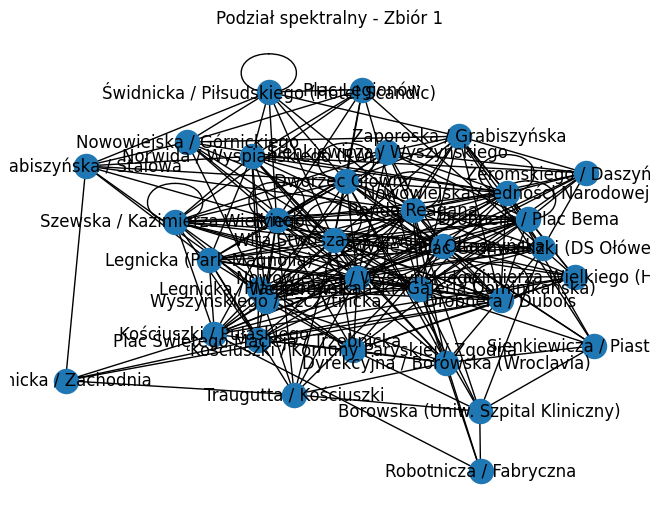

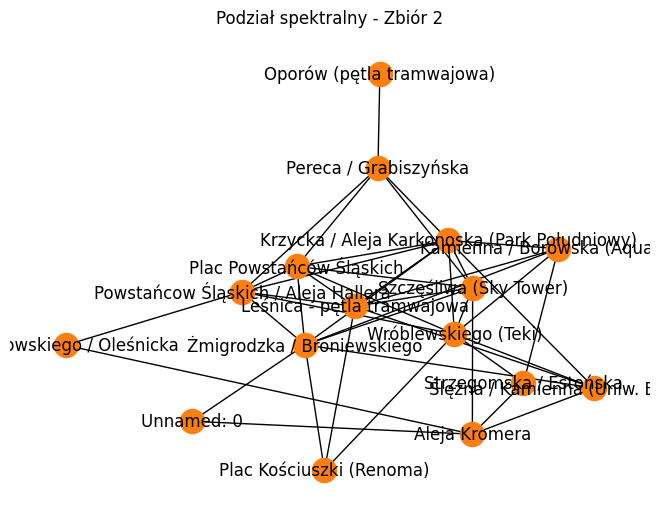

In [68]:
# Obliczanie macierzy Laplace'a
show_details = False
from sklearn.cluster import spectral_clustering
G.remove_nodes_from(list(nx.isolates(G)))
matrix = nx.to_numpy_array(G)

# Podział na dwa zbiory węzłów za pomocą metody podziału spektralnego
num_clusters = 2
labels = spectral_clustering(matrix, n_clusters=num_clusters, eigen_solver='arpack')

# Przypisanie węzłów do dwóch zbiorów na podstawie wyników podziału spektralnego
subset1 = [names[node] for node, label in enumerate(labels) if label == 0]
subset2 = [names[node] for node, label in enumerate(labels) if label == 1]

print("Podział spektralny - Zbiór 1:", subset1)
print("Podział spektralny - Zbiór 2:", subset2)
if show_details:
    draw([subset1,subset2], G, "Podział spektralny - Zbiór")

{'icoord': [[5.0, 5.0, 15.0, 15.0], [35.0, 35.0, 45.0, 45.0], [25.0, 25.0, 40.0, 40.0], [85.0, 85.0, 95.0, 95.0], [105.0, 105.0, 115.0, 115.0], [125.0, 125.0, 135.0, 135.0], [155.0, 155.0, 165.0, 165.0], [145.0, 145.0, 160.0, 160.0], [130.0, 130.0, 152.5, 152.5], [110.0, 110.0, 141.25, 141.25], [175.0, 175.0, 185.0, 185.0], [195.0, 195.0, 205.0, 205.0], [245.0, 245.0, 255.0, 255.0], [235.0, 235.0, 250.0, 250.0], [225.0, 225.0, 242.5, 242.5], [215.0, 215.0, 233.75, 233.75], [200.0, 200.0, 224.375, 224.375], [265.0, 265.0, 275.0, 275.0], [285.0, 285.0, 295.0, 295.0], [270.0, 270.0, 290.0, 290.0], [315.0, 315.0, 325.0, 325.0], [305.0, 305.0, 320.0, 320.0], [345.0, 345.0, 355.0, 355.0], [375.0, 375.0, 385.0, 385.0], [395.0, 395.0, 405.0, 405.0], [380.0, 380.0, 400.0, 400.0], [415.0, 415.0, 425.0, 425.0], [390.0, 390.0, 420.0, 420.0], [365.0, 365.0, 405.0, 405.0], [435.0, 435.0, 445.0, 445.0], [385.0, 385.0, 440.0, 440.0], [350.0, 350.0, 412.5, 412.5], [335.0, 335.0, 381.25, 381.25], [312.5

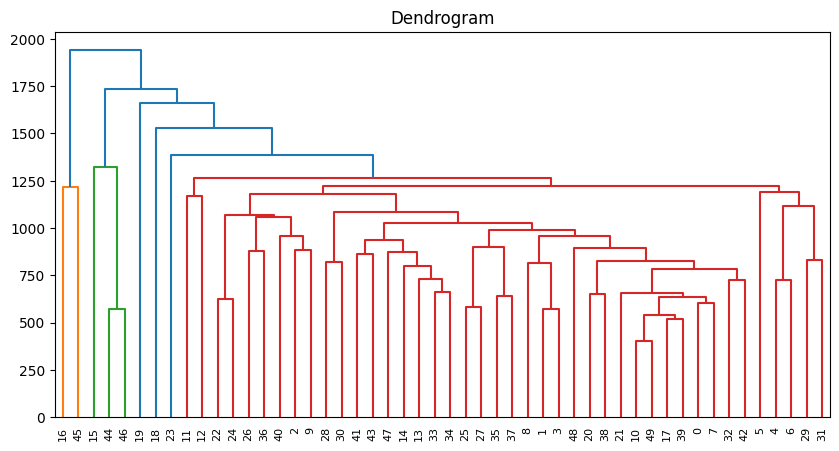

In [71]:
distance_matrix = nx.to_numpy_array(G)
Z = hierarchy.linkage(distance_matrix, method='complete')
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z)
print(dn)
plt.title('Dendrogram')
plt.show()